# EDA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

Data can be accessed from this google drive link. The "play log" contains the records of users active session. There are 9 mini games inside the app "Lengbear", an social casino games made and publish exclusively for Cambodia. The transactions log is the records of user in app purchase.

In [2]:
# Load the transactions log data

transactions_df=pd.read_csv('data/transactions.csv', index_col=0, infer_datetime_format=True)
transactions_df.head()

,UserID,Amount,Chips,Date,Channel
0,4403840,0.5,600000,2020-03-04 00:00:09.270,DCB_Smart_Axiata
1,4209368,1.0,2000000,2020-03-04 00:01:07.777,Wing
2,4627993,0.2,200000,2020-03-04 00:01:15.257,DCB_Smart_Axiata
3,4689823,0.2,200000,2020-03-04 00:01:53.540,DCB_Smart_Axiata
4,5209800,0.2,200000,2020-03-04 00:02:11.197,DCB_Smart_Axiata


In [3]:
# Check if there is any missing values

transactions_df.isna().sum()

UserID     0
Amount     0
Chips      0
Date       0
Channel    0
dtype: int64

In [4]:
# Inspect the columns and datatype

transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342544 entries, 0 to 342543
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   UserID   342544 non-null  int64  
 1   Amount   342544 non-null  float64
 2   Chips    342544 non-null  int64  
 3   Date     342544 non-null  object 
 4   Channel  342544 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 15.7+ MB


In [5]:
# Slice away the purchasing time for date in transaction data

transactions_df['Date']=pd.to_datetime(transactions_df['Date'].str[:10])
transactions_df.head()

,UserID,Amount,Chips,Date,Channel
0,4403840,0.5,600000,2020-03-04,DCB_Smart_Axiata
1,4209368,1.0,2000000,2020-03-04,Wing
2,4627993,0.2,200000,2020-03-04,DCB_Smart_Axiata
3,4689823,0.2,200000,2020-03-04,DCB_Smart_Axiata
4,5209800,0.2,200000,2020-03-04,DCB_Smart_Axiata


In [6]:
# Calculate sales by day

transactions_df_sum=pd.DataFrame(transactions_df.groupby('Date').sum()['Amount']).reset_index()
transactions_df_sum['Day']=pd.to_datetime(transactions_df_sum['Date']).dt.day_name()
transactions_df_sum.head()

,Date,Amount,Day
0,2020-03-04,6412.86,Wednesday
1,2020-03-05,5419.21,Thursday
2,2020-03-06,6745.30,Friday
3,2020-03-07,6040.70,Saturday
4,2020-03-08,7039.80,Sunday


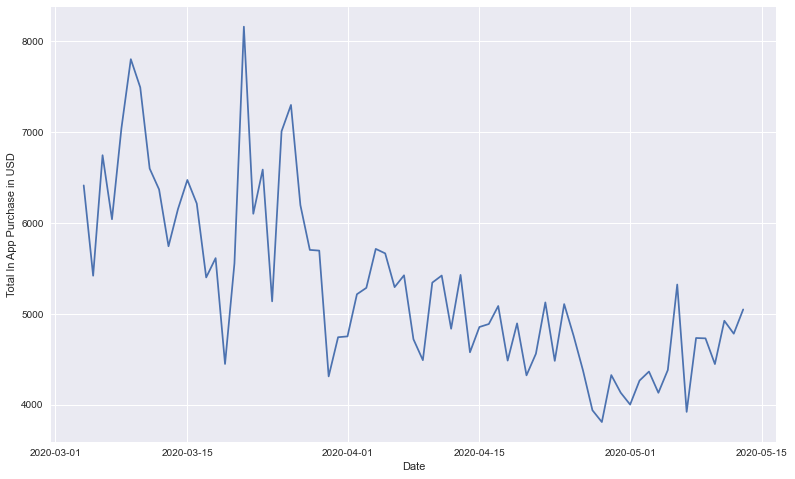

In [7]:
# Visualize sales by day of the period

plt.figure(figsize=(13,8))
sns.lineplot(transactions_df_sum['Date'], transactions_df_sum['Amount'], sizes=(13,8))
plt.ylabel('Total In App Purchase in USD')
plt.savefig('IAP by data.png', dpi=400)
plt.show()

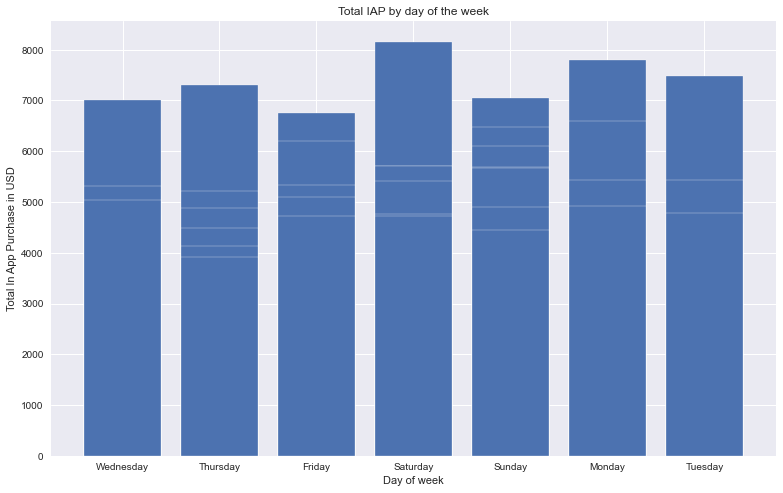

In [8]:
# Visualize sales by day of week 

plt.figure(figsize=(13,8))
plt.bar(transactions_df_sum['Day'], transactions_df_sum['Amount'])
plt.xlabel('Day of week')
plt.ylabel('Total In App Purchase in USD')
plt.title('Total IAP by day of the week')
plt.savefig('Total IAP by day of the week.png', dpi=400)
plt.show()

In [9]:
# Count the Amount generated by each in app purchase channel and the number of use

transactions_iap_by_channels=transactions_df.groupby('Channel').sum()['Amount'].reset_index()
transactions_iap_by_channels['Use_Count']=transactions_iap_by_channels['Channel'].map(transactions_df['Channel'].value_counts())
transactions_iap_by_channels=transactions_iap_by_channels.sort_values('Amount', ascending=False).set_index('Channel')
transactions_iap_by_channels

,Amount,Use_Count
Channel,,
DCB_Smart_Axiata,162931.61,226264
Wing,114243.00,35917
DCB_Cellcard_Coda,65953.20,70179
Wing_Local,25946.59,5712
DCB_Metfone_Coda,3277.50,2941
Asia,2886.00,1052
Pipay,1592.00,478
DCB_Unitel,0.23,1


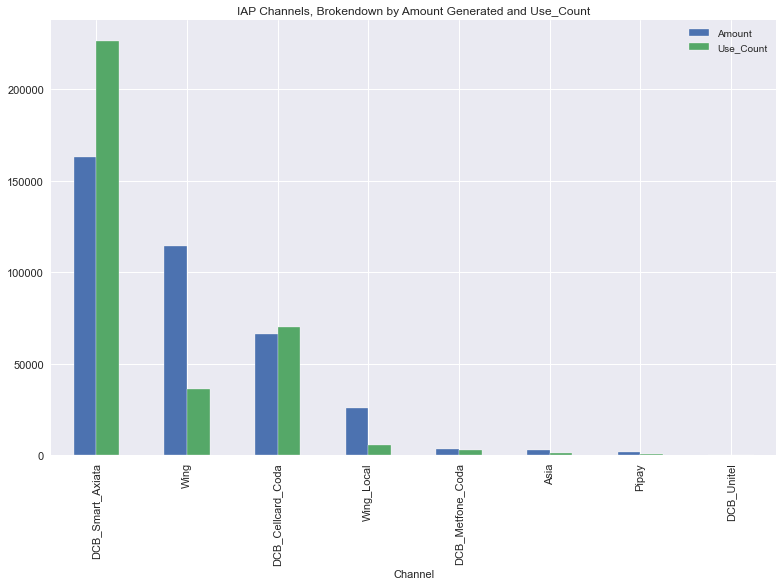

In [10]:
# Plot IAP Channels, brokendown by amount generated and Use_Count

fig=transactions_iap_by_channels.plot(kind='bar', figsize=(13,8), fontsize=11, title='IAP Channels, Brokendown by Amount Generated and Use_Count').get_figure()
fig.savefig('IAP Channels, brokendown by amount generated and Use_Count.pdf', dpi=400)

In [11]:
# Load the play log file and check if there is any missing values

play_log_df=pd.read_csv('data/playlog01-130520.csv', index_col=0)
play_log_df.head()

/Users/Ben/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Sequence,UserID,GameID,Level,WinNo,DrawNo,LostNo,WinAmt,LostAmt,Date,Currency_Type1,Currency_Type2
0,50518638,5894561,9009,1000,0,0,1,0,24964,2020-05-09 00:00:00.000,0,0
1,50518637,6047531,9009,20,2,0,0,515,0,2020-05-09 00:00:00.000,0,0
2,50518636,4972744,9009,100,1,0,3,1748,7800,2020-05-09 00:00:00.000,0,0
3,50518635,5608136,9009,1000,9,0,15,128680,137000,2020-05-09 00:00:00.000,0,0
4,50518634,4725768,9009,100,10,0,34,18272,27100,2020-05-09 00:00:00.000,0,0


In [12]:
# Check if there is any missing value

play_log_df.isna().sum()

Sequence          0
UserID            0
GameID            0
Level             0
WinNo             0
DrawNo            0
LostNo            0
WinAmt            0
LostAmt           0
Date              0
Currency_Type1    0
Currency_Type2    0
dtype: int64

In [13]:
# Review play_log data frame

play_log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1768640 entries, 0 to 1768639
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Sequence        int64 
 1   UserID          int64 
 2   GameID          int64 
 3   Level           int64 
 4   WinNo           int64 
 5   DrawNo          int64 
 6   LostNo          int64 
 7   WinAmt          int64 
 8   LostAmt         int64 
 9   Date            object
 10  Currency_Type1  int64 
 11  Currency_Type2  int64 
dtypes: int64(11), object(1)
memory usage: 175.4+ MB


In [14]:
# Further reviewing data in each column

play_log_df.describe()

,Sequence,UserID,GameID,Level,WinNo,DrawNo,LostNo,WinAmt,LostAmt,Currency_Type1,Currency_Type2
count,1.768640e+06,1.768640e+06,1.768640e+06,1.768640e+06,1.768640e+06,1768640.0,1.768640e+06,1.768640e+06,1.768640e+06,1768640.0,1768640.0
mean,5.028838e+07,5.173211e+06,8.710541e+03,7.668269e+03,5.716449e+00,0.0,1.188716e+01,5.630973e+05,6.238427e+05,0.0,0.0
std,5.105625e+05,1.269449e+06,1.509552e+03,6.928382e+04,1.421466e+01,0.0,4.580591e+01,9.817862e+06,1.018438e+07,0.0,0.0
min,4.940406e+07,1.230000e+02,1.008000e+03,2.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
25%,4.984622e+07,4.952213e+06,9.002000e+03,1.000000e+02,0.000000e+00,0.0,2.000000e+00,0.000000e+00,1.240000e+03,0.0,0.0
50%,5.028838e+07,5.776227e+06,9.009000e+03,1.000000e+02,2.000000e+00,0.0,4.000000e+00,1.855000e+03,7.000000e+03,0.0,0.0
75%,5.073054e+07,5.972449e+06,9.009000e+03,1.000000e+03,6.000000e+00,0.0,1.000000e+01,2.226425e+04,3.971025e+04,0.0,0.0
max,5.117270e+07,6.104168e+06,9.009000e+03,1.000000e+07,1.383000e+03,0.0,6.482000e+03,2.525479e+09,2.567000e+09,0.0,0.0


In [15]:
# Remove redundant columns namely: Sequence, DrawNo, Currency_Type1, Currency_Type2 since they are all 0 and set the time to regular format

play_log_df.drop(['Sequence', 'DrawNo', 'Currency_Type1', 'Currency_Type2'], axis=1, inplace=True)
play_log_df['Date']=pd.to_datetime(play_log_df['Date'].str[:10])
play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date
0,5894561,9009,1000,0,1,0,24964,2020-05-09
1,6047531,9009,20,2,0,515,0,2020-05-09
2,4972744,9009,100,1,3,1748,7800,2020-05-09
3,5608136,9009,1000,9,15,128680,137000,2020-05-09
4,4725768,9009,100,10,34,18272,27100,2020-05-09


In [16]:
# Making the dataframe for GameID and Match_Length in seconds (data provided by game owner)

# Gamename BINH                9001: 80 seconds
# Gamename POKDENG             9002: 80 seconds
# Gamename BAUCUA              9005: 20 seconds
# Gamename SHOW                9004: 80 seconds
# Gamename XOCDIA              9003: 20 seconds
# Gamename SIKU                9006: 80 seconds
# Gamename SLOT_20_LINE        9008: 20 seconds
# Gamename SLOT_100_LINE       1008: 20 seconds
# Gamename TIENLEN_CAM         9009: 120 seconds

Game_Code_Length=pd.DataFrame({'GameID':[9001, 9002, 9005, 9004, 9003, 9006, 9008, 1008, 9009],
                               'Match_Length':[75,75,20,75,20,75,20,20,120]})

In [17]:
# Getting the Match_Length column ready to calculate the active session of user

play_log_df=play_log_df.merge(Game_Code_Length, on='GameID', how='left')
play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date,Match_Length
0,5894561,9009,1000,0,1,0,24964,2020-05-09,120
1,6047531,9009,20,2,0,515,0,2020-05-09,120
2,4972744,9009,100,1,3,1748,7800,2020-05-09,120
3,5608136,9009,1000,9,15,128680,137000,2020-05-09,120
4,4725768,9009,100,10,34,18272,27100,2020-05-09,120


In [18]:
# Counting the number of games play in each log and get the actual active play time of users in seconds

play_log_df['Games_Played']=play_log_df['WinNo']+play_log_df['LostNo']
play_log_df['Active_Time']=play_log_df['Games_Played']*play_log_df['Match_Length']
play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date,Match_Length,Games_Played,Active_Time
0,5894561,9009,1000,0,1,0,24964,2020-05-09,120,1,120
1,6047531,9009,20,2,0,515,0,2020-05-09,120,2,240
2,4972744,9009,100,1,3,1748,7800,2020-05-09,120,4,480
3,5608136,9009,1000,9,15,128680,137000,2020-05-09,120,24,2880
4,4725768,9009,100,10,34,18272,27100,2020-05-09,120,44,5280


In [19]:
# Get lists of unique GameID and unique betting_level

gameid=list(play_log_df['GameID'].unique())
betting_level=list(play_log_df['Level'].unique())

# Count number of minigames that user play in each log
for GameID in gameid:
    play_log_df[GameID]=np.where(play_log_df['GameID']==GameID, play_log_df['Games_Played'], 0)

# Count the number of game player play in specific betting level 
for Betting_Level in betting_level:
    play_log_df[Betting_Level]=np.where(play_log_df['Level']==Betting_Level, 1, 0)

play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date,Match_Length,Games_Played,...,200000,10,20000,500000,50,2,200,10000000,5000000,2000000
0,5894561,9009,1000,0,1,0,24964,2020-05-09,120,1,...,0,0,0,0,0,0,0,0,0,0
1,6047531,9009,20,2,0,515,0,2020-05-09,120,2,...,0,0,0,0,0,0,0,0,0,0
2,4972744,9009,100,1,3,1748,7800,2020-05-09,120,4,...,0,0,0,0,0,0,0,0,0,0
3,5608136,9009,1000,9,15,128680,137000,2020-05-09,120,24,...,0,0,0,0,0,0,0,0,0,0
4,4725768,9009,100,10,34,18272,27100,2020-05-09,120,44,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Get a list of columns to aggregate later

features_list=list(play_log_df.columns)
columns_not_aggregated=['UserID', 'GameID', 'Level','Match_Length', 'Date']

for e in columns_not_aggregated:
    features_list.remove(e)

In [21]:
# Count the number of games played by GameID over the study period

user_details=play_log_df.groupby(['UserID']).sum()[features_list].reset_index()
user_details.head()

,UserID,WinNo,LostNo,WinAmt,LostAmt,Games_Played,Active_Time,9009,9005,9001,...,200000,10,20000,500000,50,2,200,10000000,5000000,2000000
0,123,0,1,0,5700,1,75,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1406,0,2,0,7000,2,150,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1980,0,3,0,417197,3,60,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3286,7,12,2998314,2048800,19,1425,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3452,15,36,13159123,18979771,51,2725,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Finding the popularity of each GameID

game_popularity_ranking=pd.DataFrame(play_log_df[gameid].sum(), columns=['Games_Played'])
game_popularity_ranking=game_popularity_ranking.sort_values(by='Games_Played', ascending=False)
game_popularity_ranking

,Games_Played
9009,13899603
9008,4294016
1008,3642275
9002,3426852
9001,2138503
9004,1128779
9006,1056904
9005,1028123
9003,519401


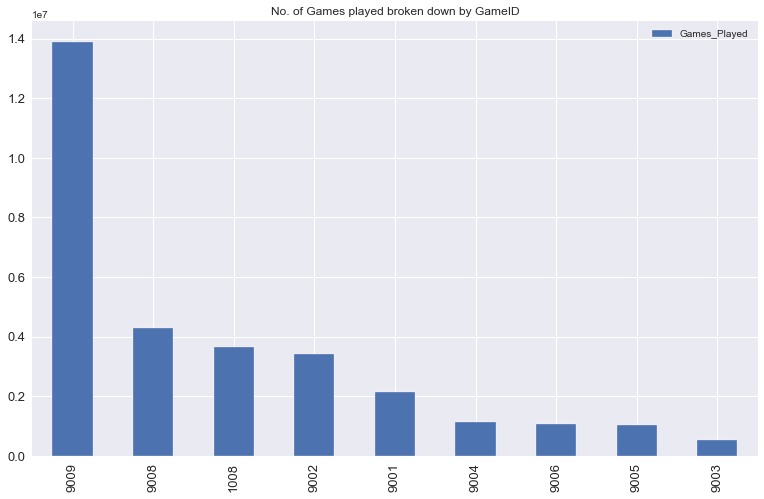

In [23]:
fig=game_popularity_ranking.plot(kind='bar', figsize=(13,8), fontsize=13, title='No. of Games played broken down by GameID').get_figure()
fig.savefig('No. of Games played broken down by GameID.png', dpi=400)

# Clearly GameId: 9009, 9008, 1008 and 9002 are the ones that has the most number of matches played. It is probably where users spend most of their time playing too. If any promotion banner is to take place, it should be paid extra attention. 

In [27]:
# Finding the popularity of each GameID

betting_level_popularity=pd.DataFrame(play_log_df[betting_level].sum(), columns=['Betting_Level'])
betting_level_popularity=betting_level_popularity.sort_values(by='Betting_Level', ascending=False)
betting_level_popularity

,Betting_Level
100,556734
1000,319266
20,181872
500,176679
10,132396
10000,123566
50,94311
5000,53137
50000,35595
100000,30426


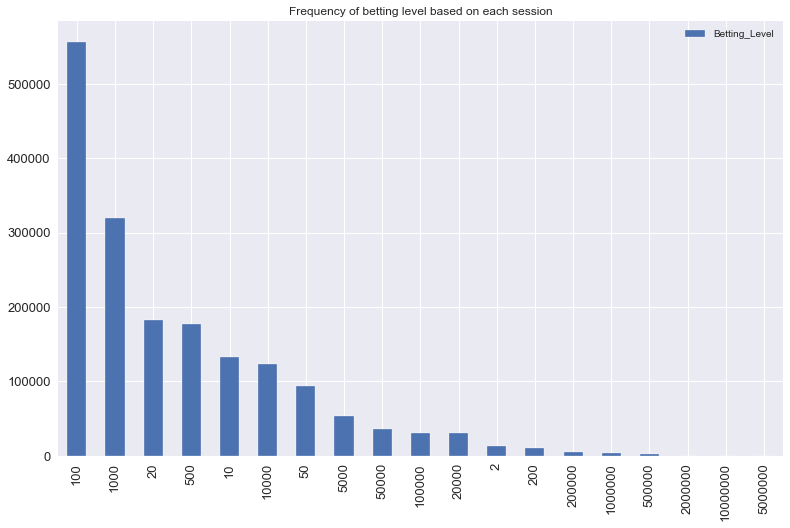

In [29]:
fig=betting_level_popularity.plot(kind='bar', figsize=(13,8), fontsize=13, title='Frequency of betting level based on each session').get_figure()
fig.savefig('Betting Level Popularity.png', dpi=400)

In [30]:
# Getting t0 and list of days on which user data can be extracted

t0=play_log_df['Date'].min()
t_value=[]

for i in range(0,9):
    t_value.append(t0+datetime.timedelta(days=i))
    
print(f'The data set can have t0 can start from: {t_value[0]}, to: {t_value[-1]}, pass t_value[number] to function get_data to get the desired player data')

The data set can have t0 can start from: 2020-05-01 00:00:00, to: 2020-05-09 00:00:00, pass t_value[number] to function get_data to get the desired player data


In [ ]:
def get_data(t0):
    
    # Pass in t0, t4 and tchurn
    t0=t0
    t4=t0+datetime.timedelta(days=3)
    tchurn=t0+datetime.timedelta(days=4)
    print(f't0={t0} \nt4={t4} \ntchurn={tchurn}')
    
    # Get unique users on t0
    play_log_t0=play_log_df.loc[play_log_df['Date']==t0]
    t0_users=pd.DataFrame(play_log_t0['UserID'].unique(), columns=['UserID'])
    
    # Slice out the dataframe that contains user playlog from t0 -> t4
    play_log_t0_t4=play_log_df.loc[(play_log_df['Date']>=t0) & (play_log_df['Date']<=t4)]
    
    # Compute the Winning rate and Drawing rate, Losing Rate, Winning Amount, Losing Amount for each user in from t0->t4
    WinNo=pd.DataFrame(play_log_t0_t4.groupby(['UserID']).sum()['WinNo'])
    LostNo=pd.DataFrame(play_log_t0_t4.groupby(['UserID']).sum()['LostNo'])
    WinAmt=pd.DataFrame(play_log_t0_t4.groupby(['UserID']).sum()['WinAmt'])
    LostAmt=pd.DataFrame(play_log_t0_t4.groupby(['UserID']).sum()['LostAmt'])
    Games_Played=pd.DataFrame(play_log_t0_t4.groupby(['UserID']).sum()['Games_Played'])
    Active_Time=pd.DataFrame(play_log_t0_t4.groupby(['UserID']).sum()['Active_Time'])
    
    # Count the number of games played by GameID over the study period
    games_played_breakdown=play_log_df.groupby(['UserID']).sum()[['9001', '9002', '9005', '9004', '9003', '9006', '9008', '1008', '9009']].reset_index()
        
    # Merging user data into a single dataframe 
    play_log_summary=WinNo.merge(LostNo, on='UserID', how='left')\
                        .merge(WinAmt, on='UserID', how='left')\
                        .merge(LostAmt, on='UserID', how='left')\
                        .merge(Games_Played, on='UserID', how='left')\
                        .merge(Active_Time, on='UserID', how='left')
    play_log_summary.columns=['WinNo', 'LostNo', 'WinAmt', 'LostAmt', 'Games_Played', 'Active_Time']
    
    # Reset index after merging all new 
    play_log_summary=play_log_summary.reset_index(level='UserID')
        
    # Slice out the time for study
    transactions_df_t0_t4=transactions_df.loc[(transactions_df['Date']>=t0) & (transactions_df['Date']<=t4)]
    
    # Sum in-game purchase by users during t0 -> t4
    transactions_df_t0_t4=pd.DataFrame(transactions_df_t0_t4.groupby(['UserID']).sum()['Amount'])
    transactions_df_t0_t4.reset_index(level='UserID')
    
    # Merge transactions records with play log
    play_log_summary=play_log_summary.merge(transactions_df_t0_t4, on='UserID', how='left')
    play_log_summary=play_log_summary.fillna(0)
    
    # Create new features namely: Winning Rate, Drawing Rate, Losing Rate for all unique users
    play_log_summary['WinningRate']=play_log_summary['WinNo']/play_log_summary['Games_Played']
    play_log_summary['LosingRate']=play_log_summary['LostNo']/play_log_summary['Games_Played']
    
    # Slice out tchurn
    play_log_tchurn=play_log_df.loc[play_log_df['Date']==tchurn]
    
    # Getting target 
    final_play_log=play_log_summary.assign(Churn=play_log_summary.UserID.isin(play_log_tchurn.UserID).astype(int))

    return final_play_log

In [ ]:
play_log_train=get_data(t_value[0])
play_log_train

# Correlation with churn

In [ ]:
play_log_df.corr().style.background_gradient()

In [ ]:
# Assigning X_train and y_train
X_train=play_log_train.iloc[:,:-1]
X_train=X_train.drop(['UserID'], axis=1)

# Fill na for some value of 
X_train=X_train.fillna(0) 
X_train.shape

In [ ]:
y_train=play_log_train.iloc[:,-1]

In [ ]:
y_train.value_counts()

## Clearly, this is an imbalance data set which can result in inaccuracy for classification models. We will resample the data sets to make it more balance.

In [ ]:
from sklearn.utils import resample

In [ ]:

print('Number of class 0 examples before:', X_train[y_train == 0].shape[0])

X_downsampled, y_downsampled = resample(X_train[y_train == 0], 
                                        y_train[y_train == 0], 
                                        replace=True, 
                                        n_samples=X_train[y_train == 1].shape[0], 
                                        random_state=42)

print('Number of class 0 examples after:', X_downsampled.shape[0])

# Combine upsample with original data
X_train_downsampled = np.vstack((X_train[y_train == 1], X_downsampled))
y_train_downsampled = np.hstack((y_train[y_train == 1], y_downsampled))

In [ ]:
# Get a new set of users as the test set 

play_log_test=get_data(t_value[6])
play_log_test

In [ ]:
# Assigning X_test and y_test
X_test=play_log_test.iloc[:,:-1]
X_test=X_test.drop(['UserID'], axis=1)

# Fill na for some value of 
X_test=X_test.fillna(0) 

In [ ]:
y_test=play_log_test.iloc[:,-1]
y_test.value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression

# 1. Instantiate model
churn_logistic_regression=LogisticRegression(random_state=42, max_iter=10000)

# 2. Fit model
churn_logistic_regression.fit(X_train_downsampled, y_train_downsampled)

In [ ]:
# 3. Score model
print(f'Score on train: {churn_logistic_regression.score(X_train_downsampled, y_train_downsampled)}')
print(f'Score on test: {churn_logistic_regression.score(X_test, y_test)}')

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT=DecisionTreeClassifier(random_state=42, max_depth=11)
DT.fit(X_train, y_train)

# Accuracy scores
print(DT.score(X_train_downsampled, y_train_downsampled))
print(DT.score(X_test, y_test))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# k_ranges = range(1,15)
# train_scores = []
# validation_scores = []

# for k in k_ranges:
my_knn = KNeighborsClassifier(n_neighbors=13)
my_knn.fit(X_train, y_train)
    
# train_scores.append(my_knn.score(X_train, y_train))
# validation_scores.append(my_knn.score(X_test, y_test))

print(my_knn.score(X_train_downsampled, y_train_downsampled))
print(my_knn.score(X_test, y_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

estimator_number = list(range(1, 100))
train_scores = []
test_scores = []


for number in estimator_number:
    my_model = RandomForestClassifier(n_estimators=number, 
                                      max_depth=1,
                                      random_state=1)
    my_model.fit(X_train_downsampled, y_train_downsampled)

    train_scores.append(my_model.score(X_train_downsampled, y_train_downsampled))
    test_scores.append(my_model.score(X_test, y_test))
    
    print(f'finished {number} estimators', end='\r')

In [ ]:
plt.figure()
plt.plot(estimator_number, train_scores, label="Train")
plt.plot(estimator_number, test_scores, label="Test")
plt.xlabel("Estimator number")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
my_skl_model = MLPClassifier(hidden_layer_sizes=(10), 
                             activation='relu',
                             max_iter=2000,
                             solver = 'adam')

In [ ]:
# 3. Fit
my_skl_model.fit(X_train_downsampled, y_train_downsampled)

In [ ]:
# 3. Score
print(my_skl_model.score(X_train_downsampled, y_train_downsampled))
print(my_skl_model.score(X_test, y_test))

In [ ]:
# importing the feed-forward network object
from tensorflow.keras.models import Sequential

# importing the required type of layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [ ]:
# Instantiate feed-forward neural network
my_keras_model = Sequential()

In [ ]:
# adding appropriate layers

# hidden layer with relu activation function and 10 nodes
my_keras_model.add(Dense(units=10, 
                         activation='relu', 
                         input_shape=(11,))) 
# shape of data points come in the model
# the next layer you dont need to put in input_shape
# output layer with softmax and 3 output nodes
my_keras_model.add(Dense(units=2,
                         activation='softmax')) #classification problem use softmax

In [ ]:
# compile model with proper optimizer, loss and a metric
my_keras_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy']) #loss function is what we want to optimize

In [ ]:
# fit model 
my_keras_model.fit(X_train_downsampled, y_train_downsampled, epochs=2000, verbose=0) 
# epoch is the number of iteration, 
# verbose stops the function printing everytime it finishes one iteration 

In [ ]:
# training score
my_keras_model.evaluate(X_train_downsampled, y_train_downsampled)

In [ ]:
# testing score
my_keras_model.evaluate(X_test, y_test)